In [49]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
import numpy as np
import scipy as sp
from scipy.integrate import odeint

In [113]:
time = 10*np.pi # total time in seconds
dt=0.025 # Timestep
nt = int(time / dt) # number of time steps
t0=0;
order = 2 # order of symplectic integrator
t=np.linspace(t0,nt*dt,nt) #Iniatialize time array

# define initial conditions and physical parameters
theta0= np.pi*np.array([0.5,0.5]) # initial position vector
u0 = np.pi*np.array([0,0]) # initial velocity vector
params = {"L":1.0,"g":10.0}

# position update function
def f(theta,u,t,params):
    return u

# velocity update function
def g(theta,u,t,params):
    L = params["L"]; grav = params["g"];
    th1 = theta[0]; th2 = theta[1];
    c = np.cos(th1-th2); s = np.sin(th1-th2);
    
    denom = L*(23 - 9*np.cos(2*(th1-th2)))
    
    num1 = -3*(3*grav*(3*np.sin(th1) + np.sin(th1-2*th2)) + 
              3*L*np.sin(2*(th1-th2))*u[0]**2 + 4*L*np.sin(th1-th2)*u[1]**2)
    
    num2 = 3*(9*grav*np.sin(2*th1-th2) - 7*grav*np.sin(th2) + 
              16*L*np.sin(th1-th2)*u[0]**2 + 3*L*np.sin(2*(th1-th2))*u[1]**2)
    
    return np.array([num1,num2])/denom
    

In [114]:
# Euler's method (1st order symplectic)
def euler(t,dt,theta0,u0,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
    
    for i in range(nt-1):
        u[:,i+1] = u[:,i] + dt*g(theta[:,i],u[:,i],t,params)        
        theta[:,i+1] = theta[:,i] + dt*f(theta[:,i],u[:,i+1],t,params) # Semi-implicit Euler's method
    return [theta,u]

def verlet(t,dt,theta0,u0,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
    
    for i in range(nt-1):
        
        theta[:,i+1] = theta[:,i] + dt*f(theta[:,i],u[:,i],t,params) + g(theta[:,i],u[:,i],t,params)*0.5*dt**2
        u[:,i+1] = u[:,i] + 0.5*dt*g(theta[:,i],u[:,i],t,params)
        u[:,i+1] = u[:,i+1] + 0.5*dt*g(theta[:,i+1],u[:,i+1],t,params)
        
    return [theta,u]

# Symplectic integrator
def symplectic(t,dt,theta0,u0,order,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
        
    if (order == 1):
        c = np.array([1, 0, 0, 0])
        d = np.array([1, 0, 0, 0])
    elif (order == 2):
        #c = np.array([0, 1, 0, 0])
        #d = np.array([0.5, 0.5, 0, 0])
        return verlet(t,dt,theta0,u0,params)
    elif (order == 3):
        c = np.array([1, -2.0/3, 2.0/3, 0])
        d = np.array([-1.0/24, 3.0/4, 7.0/24, 0])
    elif(order == 4):
        x = 2 - 2**(1./3)
        c = np.array([1/(2*x), (1-2**(1./3))/(2*x), (1-2**(1./3))/(2*x), 1/(2*x)])
        d = np.array([1/x, -2**(1/3)/x, 1/x, 0])
    for i in range(nt-1):                              
        u[:,i+1] = u[:,i] + d[0]*dt*g(theta[:,i],u[:,i],t[i],params)
        theta[:,i+1] = theta[:,i] + c[0]*dt*f(theta[:,i],u[:,i+1],t[i+1],params)
    
        u[:,i+1] = u[:,i+1] + d[1]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[1]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[2]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[2]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
        u[:,i+1] = u[:,i+1] + d[3]*dt*g(theta[:,i+1],u[:,i+1],t[i],params)
        theta[:,i+1] = theta[:,i+1] + c[3]*dt*f(theta[:,i+1],u[:,i+1],t[i+1],params)
        
    return [theta,u]

In [115]:
# Solve 

def deriv(sol,t,L,grav):
    params = {"L":L,"g":grav}
    th1,th2,u1,u2 = sol
    
    dth  = f(np.array([th1,th2]),np.array([u1,u2]),t,params)
    du = g(np.array([th1,th2]),np.array([u1,u2]),t,params)
        
    return [dth[0],dth[1],du[0],du[1]]

init = [theta0[0],theta0[1],u0[0],u0[1]]
sol = odeint(deriv,init,t,args=(params["L"],params["g"]))
thetaSP = np.transpose(sol[:,0:2])
uSP = np.transpose(sol[:,2:])

theta,u = symplectic(t,dt,theta0,u0,order,params)

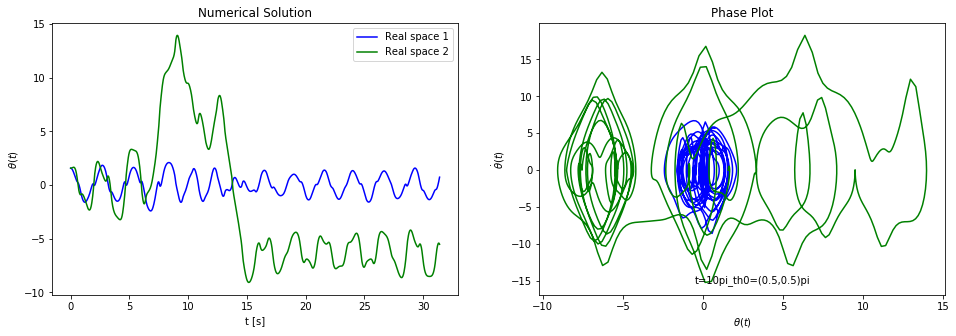

In [116]:
# Plot results
runInfo = "t="+str(int(time/np.pi))+"pi_"+"th0=("+str(theta0[0]/np.pi)+","+str(theta0[1]/np.pi)+")pi"

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(t,theta[0,:],label="Real space 1",color="b")
ax1.plot(t,theta[1,:],label="Real space 2",color="g")
#ax1.plot(t,thetaSP[0,:],label="Real space 1 odeint",color="r")
#ax1.plot(t,thetaSP[1,:],label="Real space 2 odeint",color="k")

ax2.plot(theta[0,:],u[0,:],label="Phase space 1",color="b")
ax2.plot(theta[1,:],u[1,:],label="Phase space 2",color="g")

ax1.set_xlabel('t [s]'); ax1.set_ylabel(r'$\theta(t)$');
ax2.set_xlabel(r'$\theta(t)$'); ax2.set_ylabel(r'$\dot{\theta}(t)$');
ax1.legend()
ax1.set_title("Numerical Solution")
ax2.set_title("Phase Plot")
plt.text(np.median(theta),np.min(u),runInfo)
plt.savefig("figures/" + runInfo + "doublePend.png",bbox_inches='tight')
plt.show()

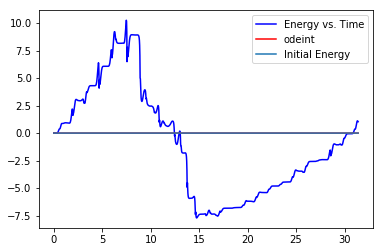

In [117]:
# Energy calculations

def energy(theta,u,L,g):
    # Potetial energy
    V = -0.5*L*g*(3*np.cos(theta[0]) + np.cos(theta[1]))
    T = (4*u[0]**2 + u[1]**2 + 3*u[0]*u[1]*np.cos(theta[0]-theta[1]))*L**2 / 6
    
    return T+V

E = energy(theta,u,params["L"],params["g"]) # Energy over time
ESP = energy(thetaSP,uSP,params["L"],params["g"])
E0 = energy(theta0,u0,params["L"],params["g"]) # Initial energy

plt.plot(t,E,label="Energy vs. Time",color="b")
plt.plot(t,ESP,label="odeint",color="r")
plt.plot(t,E0*np.ones(t.size),label="Initial Energy")
plt.legend()
plt.show()

In [64]:
# Visualize pendulum trajectory
# joint location -> (x1,y1) = (L*sin(th1),-L*cos(th1))
# end location   -> (x2,y2) = (x1,y1) + L*(sin(th2),-cos(th2))       

#%load_ext line_profiler

def animate(pos):    
    x = pos[0:3]
    y = pos[3:]
    line.set_data(x,y)
    
    return line,

L = params["L"]

x1 = L*np.sin(theta[0]); y1 = -L*np.cos(theta[0]);
x2 = x1 + L*np.sin(theta[1]); y2 = y1 - L*np.cos(theta[1]);

pos = np.transpose(np.array([np.zeros(nt),x1,x2,np.zeros(nt),y1,y2]))

fig = plt.figure()
ax = plt.axes(xlim=(-2*L,2*L),ylim=(-2*L,2*L))
line, = ax.plot([],[],lw=6,color="r")
info = "L={:.2f} theta0=({:.3f},{:.3f}) time={:.3f}s".format(L,theta0[0],theta0[1],time)

plt.text(-1.8*L,1.8*L,info)

anim = animation.FuncAnimation(fig,animate,frames=pos,interval=10)
#anim.save(info) # not working
display_animation(anim)

KeyboardInterrupt: 

In [65]:
# Lyapunov exponent

def lyapunov(th0,u0,pert,t,dt,params):
    thP = th0*(1+pert) # perturb th0
    theta,u = verlet(t,dt,th0,u0,params)
    thetaP,uP = verlet(t,dt,thP,u0,params)
    
    dif = np.sum((theta - thetaP)**2,0) # 2-norm of difference in trajectory
    lamb = (1/t[-1])*np.sum(np.log(dif/pert)) # calculate Lyapunov exponent, lambda
    
    return lamb,dif

pert = 0.001 # slight perturbation of theta0


th0 = np.pi*np.array([0.3,0.3]) 
lam,dif = lyapunov(th0,u0,pert,t,dt,params)

print(lam)

-449.831613904


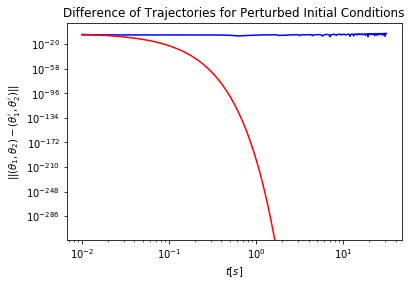

In [66]:
# Plot for Lyapunov exponent

plt.loglog(t,dif,'b') # log(dif) ~ lambda*t*log(pert0-th0)
plt.loglog(t,pert*np.exp(lam*t),'r')
plt.xlabel(r"$t [s]$")
plt.ylabel(r"$||(\theta_{1},\theta_{2})-(\theta_{1}',\theta_{2}')||$")
plt.title("Difference of Trajectories for Perturbed Initial Conditions")
plt.axis()
plt.show()

In [120]:
numTh = 20
thetas = np.linspace(0.4,1,numTh)*np.pi
lams = np.zeros(thetas.size)
energies = np.zeros(thetas.size)

for i in range(thetas.size):
    print(np.around(100*i/numTh,1),end="%\r") #display progress of calculations)
    for j in range(thetas.size)
        th0 = np.array([thetas[i],thetas[j]])
        lams[i] = lyapunov(th0,u0,pert,t,dt,params)[0]
        energies[i] = energy(th0,u0,params["L"],params["g"])


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in cos
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in sin
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in cos
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in sin
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sin
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:29: 

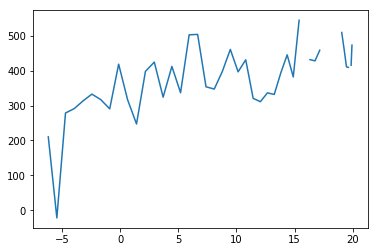

In [122]:
plt.plot(energies,lams)
plt.show()

In [ ]:
# Time for pendulum to flip

def timeToFlip(t,dt,theta0,u0,params):
    theta=np.zeros([2,nt])
    u=np.zeros([2,nt])
    theta[:,0]=theta0
    u[:,0]=u0
    
    for i in range(nt-1):
        theta[:,i+1] = theta[:,i] + dt*f(theta[:,i],u[:,i],t,params) + g(theta[:,i],u[:,i],t,params)*0.5*dt**2
        u[:,i+1] = u[:,i] + 0.5*dt*g(theta[:,i],u[:,i],t,params)
        u[:,i+1] = u[:,i+1] + 0.5*dt*g(theta[:,i+1],u[:,i+1],t,params)
        
        if (theta[0,i+1] > np.pi or theta[1,i+1] > np.pi):
            return (i+1)*dt
        
    return np.nan

time = 20*np.sqrt(params["L"]/params["g"])
t = np.linspace(t0,time,int(time/dt))
numTh = 600
thetas = np.linspace(0,np.pi,numTh)

flipTime = np.zeros([numTh,numTh])

for i in range(numTh):
    print(np.around(100*i/numTh,1),end="%\r") #display progress of calculations
    for j in range(numTh):
        if (3*np.cos(thetas[i]) + np.cos(thetas[j]) > 2):
            flipTime[i,j] = np.nan
        else:
            theta0 = [thetas[i],thetas[j]]
            flipTime[i,j] = timeToFlip(t,dt,theta0,u0,params)



In [ ]:
# Create unique filename for flip data
fname = str(numTh) + "x" + str(numTh) + "_" + str(int(time/np.sqrt(params["L"]/params["g"]))) 
np.savetxt("figures/" + fname + ".txt",flipTime) # save as text and numpy binary
np.save("figures/" + fname + ".npy",flipTime)

# Plot of flip time
Th1,Th2 = np.meshgrid(thetas,thetas)

plt.contourf(Th1,Th2,flipTime)
plt.xlabel(r"$\theta_{1}$")
plt.ylabel(r"$\theta_{2}$")
plt.title("Time to Flip")
plt.colorbar()
plt.savefig("figures/" + fname + ".png",bbox_inches='tight')
plt.show()

[[   nan    nan    nan ...,    nan    nan    nan]
 [   nan    nan    nan ...,    nan    nan    nan]
 [   nan    nan    nan ...,    nan    nan    nan]
 ..., 
 [   nan    nan    nan ...,  13.95   0.3    0.05]
 [  5.15    nan    nan ...,   0.5    8.     0.05]
 [   nan    nan    nan ...,   0.05   0.05   3.2 ]]
